In [1]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Using TensorFlow backend.


In [2]:
def mergeSample(ix1_te,ix1_tr,ix2_te,ix2_tr):
    #Now lets build a sample with signal and sideband merged
    ix_tr = np.concatenate((ix1_tr,ix2_tr))
    ix_te = np.concatenate((ix1_te,ix2_te))

    #Need to define the y
    iy_te1tmp  = np.zeros(len(ix1_te))
    iy_te2tmp  = np.ones(len(ix2_te))
    iy_te      = np.concatenate((iy_te1tmp,iy_te2tmp)) 
    iy_tr1tmp  = np.zeros (len(ix1_tr))
    iy_tr2tmp  = np.ones  (len(ix2_tr))
    iy_tr      = np.concatenate((iy_tr1tmp,iy_tr2tmp)) 
    iy_teO     = np.eye(2)[((iy_te)).astype(int)]
    iy_trO     = np.eye(2)[((iy_tr)).astype(int)]
    return ix_tr,ix_te,iy_trO,iy_teO
    
def random_sample(iXArr,iYArr,iDilution):
    tmp = np.arange(0,len(iXArr))
    np.random.shuffle(tmp)
    tmp = tmp[0:int(len(tmp)*iDilution)]
    iXArr = iXArr[tmp]
    iYArr = iYArr[tmp]
    return iXArr,iYArr

def random_split(iXArr,iYArr,iDilution):
    tmp = np.arange(0,len(iXArr))
    np.random.shuffle(tmp)
    tmp1 = tmp[0:int(len(tmp)*iDilution)]
    tmp2 = tmp[int(len(tmp)*iDilution):int(len(tmp))]
    iXArr1 = iXArr[tmp1]
    iYArr1 = iYArr[tmp1]
    iXArr2 = iXArr[tmp2]
    iYArr2 = iYArr[tmp2]
    return iXArr1,iYArr1,iXArr2,iYArr2


In [3]:
#now lets make the model
batch_size, n_epoch = 1, 15
n_hidden, z_dim = 256, 4

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

#VAE Model
def makeModel(ix_tr):
    # encoder
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

    mu = Dense(z_dim)(x_encoded)
    log_var = Dense(z_dim)(x_encoded)
    z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])    

    # decoder
    z_decoder1 = Dense(n_hidden//2, activation='relu')
    z_decoder2 = Dense(n_hidden, activation='relu')
    y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

    z_decoded = z_decoder1(z)
    z_decoded = z_decoder2(z_decoded)
    y = y_decoder(z_decoded)
    
    # loss
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss
    
    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.summary()
    
    # build decoder
    decoder_input = Input(shape=(z_dim,))
    _z_decoded    = z_decoder1(decoder_input)
    _z_decoded    = z_decoder2(_z_decoded)
    _y            = y_decoder(_z_decoded)
    generator = Model(decoder_input, _y)

    # build latentizer
    latentizer = Model(x,z)
    return vae,generator,latentizer,x,y,mu,vae_loss

#Classifier Model
def classifierModel(ix_tr,n_hidden=32):
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
    x_encoded = Dense(8, activation='relu')(x_encoded)
    y = Dense(2, activation='softmax')(x_encoded)
    classifier = Model(x, y)
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier,x,y

#now lets compare the loss functions between 5 and 9
def vaeloss(vaemodel,ix):
        result = objectives.binary_crossentropy(ix,vaemodel.predict(ix, batch_size=batch_size))* ix.shape[1]
        return result
    
#now lets train all our classifiers
def classify(iX_tr,iX_te,iY_tr,iY_te,iNHidden,iEpochs=20,iBatch=20):
    imodel,ixv,iyv = classifierModel(iX_tr,iNHidden)
    imodel.fit(iX_tr,iY_tr,shuffle=True,epochs=iEpochs,batch_size=iBatch,validation_data=(iX_te,iY_te), verbose=1)
    return imodel

def lossClassify(iX_tr,iX_te,iY_tr,iY_te,iNHidden,iVAEs,iEpochs=20,iBatch=20):
    iX_tr_loss = []
    iX_te_loss = []
    for vae in iVAEs:
        pX_tr_loss = vaeloss(vae,iX_tr)
        pX_te_loss = vaeloss(vae,iX_te)
        iX_tr_loss.append(pX_tr_loss)
        iX_te_loss.append(pX_te_loss)
    iX_te_lossN    = np.transpose(np.array(iX_te_loss))
    iX_tr_lossN    = np.transpose(np.array(iX_tr_loss))
    imodel = classify(iX_tr_lossN,iX_te_lossN,iY_tr,iY_te,iNHidden,iEpochs,iBatch)
    return imodel

#now plot the ROCS
def lossPred(iX_te,iModel,iVAEs):
    iX_te_loss = []
    for vae in iVAEs:
        pX_te_loss = vaeloss(vae,iX_te)
        iX_te_loss.append(pX_te_loss)
    iX_te_lossN    = np.transpose(np.array(iX_te_loss))
    iY_pred = iModel.predict(iX_te_lossN)
    return iY_pred

def lossN(iX_te,iVAEs):
    X_te_lossN = []
    for vae in iVAEs:
        pX_te_loss = vaeloss(vae,iX_te)
        X_te_lossN.append(pX_te_loss)
    X_te_lossN    = np.transpose(np.array(X_te_lossN))
    return X_te_lossN

#now lets compare the loss functions between 5 and 9
def vaeLatentloss(vaemodel,ix):
    result = vaemodel.predict(ix, batch_size=batch_size)
    return result

def latClassify(iX_tr,iX_te,iY_tr,iY_te,iNHidden,iVAEs,iEpochs=20,iBatch=20):
    iX_tr_lat = []
    iX_te_lat = []
    for vae in iVAEs:
        pX_tr_lat = vaeLatentloss(vae,iX_tr)
        pX_te_lat = vaeLatentloss(vae,iX_te)
        for i0 in range(pX_tr_lat.shape[1]):
            iX_tr_lat.append(pX_tr_lat[:,i0])
            iX_te_lat.append(pX_te_lat[:,i0])
    iX_te_latN    = np.transpose(np.array(iX_te_lat))
    iX_tr_latN    = np.transpose(np.array(iX_tr_lat))
    print(iX_te_latN.shape)
    imodel = classify(iX_tr_latN,iX_te_latN,iY_tr,iY_te,iNHidden,iEpochs,iBatch)
    return imodel

#now lets try this on the latent space
def latPred(iX_te,iModel,iLVAEs):
    iX_te_lat = []
    for vae in iLVAEs:
        pX_te_lat = vaeLatentloss(vae,iX_te)
        for i0 in range(pX_te_lat.shape[1]):
            iX_te_lat.append(pX_te_lat[:,i0])
    iX_te_latN    = np.transpose(np.array(iX_te_lat))
    iY_pred = iModel.predict(iX_te_latN)
    return iY_pred


In [21]:
#plotting code
fpr = dict()
tpr = dict()

def plot_roc_curve(y_ml,y,fpr,tpr,iLabel,iReverse=False):
    if iReverse:
        fpr , tpr , thresholds = roc_curve ( y[:,0] , y_ml)
    else:
        fpr , tpr , thresholds = roc_curve ( y[:,1] , y_ml)
    #plt.semilogx(fpr,tpr) 
    fpr = 1/fpr
    #print(tpr,fpr)
    fpr[np.isinf(fpr)]=1000
    auc_score=roc_auc_score( y[:,0], y_ml)  #0.8822
    if not iReverse:
        auc_score=1-auc_score
    plt.semilogy(tpr,fpr,label=(iLabel+' AUC={0:0.4f}'.format(auc_score)))
    #plt.axis([0,1,0,1]) 
    plt.ylabel('1/False Positive Rate') 
    plt.xlabel('True Positive Rate') 
    print(auc_score)

In [14]:
#define LDA
def ldaClassify(iX1_tr,iX2_tr,iVAEs):
    #using the lda
    x1_lossNtmp  = lossN(iX1_tr,iVAEs)
    x2_lossNtmp  = lossN(iX2_tr,iVAEs)
    x_lossNtmp  = np.concatenate((x1_lossNtmp,x2_lossNtmp)) 
    y_lossNtmp  = np.hstack((np.zeros(len(x1_lossNtmp)), np.ones(len(x2_lossNtmp))))
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    lda.fit(x_lossNtmp, y_lossNtmp)
    return lda

def ldaPred(iX1_te,iX2_te,lda,iVAEs):
    x1_lossNtmp = lossN(iX1_te,iVAEs)
    x2_lossNtmp = lossN(iX2_te,iVAEs)
    x1_losslda  = lda.transform(x1_lossNtmp)
    x2_losslda  = lda.transform(x2_lossNtmp)
    x_losslda   = np.concatenate((x1_losslda,x2_losslda)) 
    y_loss      = np.hstack((np.ones(len(x1_losslda)), np.zeros(len(x2_losslda))))
    y_loss      = np.eye(2)[((y_loss)).astype(int)]
    return x_losslda,y_loss

In [5]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

#Our mystery digit will be 9

#Now lets prepare a search where we just have 5 and 9
x_te5 = x_te[(y_te == 5)]
y_te5 = y_te[(y_te == 5)]
x_tr5 = x_tr[(y_tr == 5)]
y_tr5 = y_tr[(y_tr == 5)]

x_te9 = x_te[(y_te == 9)]
y_te9 = y_te[(y_te == 9)]
x_tr9 = x_tr[(y_tr == 9)]
y_tr9 = y_tr[(y_tr == 9)]

#And merge
x_te59 = x_te[np.logical_or((y_te == 5),(y_te == 9))]
y_te59 = y_te[np.logical_or((y_te == 5),(y_te == 9))]
x_tr59 = x_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_tr59 = y_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_te59 = np.eye(2)[((y_te59-5)*0.25).astype(int)]
y_tr59 = np.eye(2)[((y_tr59-5)*0.25).astype(int)]
x_tr559,x_te559,y_tr559,y_te559 = mergeSample(x_te5,x_tr5,x_te59,x_tr59)

In [7]:
#Now lets train a VAE on just 5 and 9
#Now lets train a VAE on just 5
vae9,gen9,lat9,x9,y9,mu9,vae_loss9 = makeModel(x_tr9)
vae9.fit(x_tr9,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te9, None), verbose=1)
vae9.save('vae9')

#Now finally lets do the same search with an AE on each digit
vaeN    = []
vaeNlat = []
for i0 in range(9):
    tmpx_te = x_te[(y_te == i0)]
    tmpy_te = y_te[(y_te == i0)]
    tmpx_tr = x_tr[(y_tr == i0)]
    tmpy_tr = y_tr[(y_tr == i0)]
    tmpvae,tmpgen,tmplat,tmpx,tmpy,tmpmu,tmpvae_loss = makeModel(tmpx_tr)
    tmpvae.fit(tmpx_tr,
               shuffle=True,
               epochs=n_epoch,
               batch_size=10,
               validation_data=(tmpx_te, None), verbose=1)
    vaeN.append(tmpvae)
    vaeNlat.append(tmplat)
    tmpvae.save('vae'+str(i0))

    tmplat.save('vaelat'+str(i0))

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_21 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_21.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5949 samples, validate on 1009 samples
Epoch 1/15
5949/5949 [==============================] - 13s 2ms/step - loss: 119.5107 - val_loss: 106.7694
Epoch 2/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.9350 - val_loss: 106.8130
Epoch 3/15
5949/5949 [==============================] - 13s 2ms/step - loss: 106.8284 - val_loss: 106.1446
Epoch 4/15
5949/5949 [==============================] - 10s 2ms/step - loss: 106.5323 - val_loss: 105.4886
Epoch 5/15
5949/5949 [==============================] - 11s 2ms/step - loss: 106.5583 - val_loss: 107.2180
Epoch 6/15
5949/5949 [==============================] - 13s 2ms/step - loss: 106.6502 - val_loss: 106.5816
Epoch 7/15
5949/5949 [==============================] - 13s 2ms/step - loss: 106.8585 - val_loss: 106.6557
Epoch 8/15
5949/5949 [==============================] - 13s 2ms/step - loss: 107.1389 - val_loss: 105.9497
Epoch 9/15
5949/5949 [==============================] - 14s 2ms/step - loss: 107.3745 - val_loss

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_28 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_28.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5923 samples, validate on 980 samples
Epoch 1/15
5923/5923 [==============================] - 2s 266us/step - loss: 159.5538 - val_loss: 137.2627
Epoch 2/15
5923/5923 [==============================] - 2s 261us/step - loss: 131.7612 - val_loss: 129.2698
Epoch 3/15
5923/5923 [==============================] - 1s 244us/step - loss: 126.2019 - val_loss: 127.8578
Epoch 4/15
5923/5923 [==============================] - 1s 231us/step - loss: 123.8130 - val_loss: 123.7489
Epoch 5/15
5923/5923 [==============================] - 2s 269us/step - loss: 122.3606 - val_loss: 122.8823
Epoch 6/15
5923/5923 [==============================] - 1s 235us/step - loss: 121.3141 - val_loss: 121.4727
Epoch 7/15
5923/5923 [==============================] - 1s 232us/step - loss: 120.3112 - val_loss: 123.3883
Epoch 8/15
5923/5923 [==============================] - 1s 228us/step - loss: 119.3976 - val_loss: 120.6110
Epoch 9/15
5923/5923 [==============================] - 1s 222us/step - loss: 118.5306 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_35 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_35.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6742 samples, validate on 1135 samples
Epoch 1/15
6742/6742 [==============================] - 2s 285us/step - loss: 64.6696 - val_loss: 50.3494
Epoch 2/15
6742/6742 [==============================] - 2s 248us/step - loss: 49.9638 - val_loss: 45.4913
Epoch 3/15
6742/6742 [==============================] - 2s 340us/step - loss: 45.1555 - val_loss: 43.3023
Epoch 4/15
6742/6742 [==============================] - 2s 260us/step - loss: 43.6766 - val_loss: 42.3509
Epoch 5/15
6742/6742 [==============================] - 1s 221us/step - loss: 43.0588 - val_loss: 43.0304
Epoch 6/15
6742/6742 [==============================] - 2s 275us/step - loss: 42.6137 - val_loss: 42.3782
Epoch 7/15
6742/6742 [==============================] - 2s 324us/step - loss: 42.2461 - val_loss: 41.4994
Epoch 8/15
6742/6742 [==============================] - 2s 299us/step - loss: 41.8802 - val_loss: 41.9412
Epoch 9/15
6742/6742 [==============================] - 2s 257us/step - loss: 41.5386 - val_loss: 41.357

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_42 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_42.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5958 samples, validate on 1032 samples
Epoch 1/15
5958/5958 [==============================] - 2s 260us/step - loss: 183.4825 - val_loss: 154.4311
Epoch 2/15
5958/5958 [==============================] - 1s 230us/step - loss: 149.5755 - val_loss: 144.3908
Epoch 3/15
5958/5958 [==============================] - 1s 223us/step - loss: 143.7841 - val_loss: 141.2958
Epoch 4/15
5958/5958 [==============================] - 1s 223us/step - loss: 140.6988 - val_loss: 138.0317
Epoch 5/15
5958/5958 [==============================] - 1s 229us/step - loss: 138.2012 - val_loss: 136.2036
Epoch 6/15
5958/5958 [==============================] - 1s 225us/step - loss: 136.1533 - val_loss: 134.7987
Epoch 7/15
5958/5958 [==============================] - 1s 221us/step - loss: 134.6723 - val_loss: 133.3008
Epoch 8/15
5958/5958 [==============================] - 1s 220us/step - loss: 133.4884 - val_loss: 133.6613
Epoch 9/15
5958/5958 [==============================] - 1s 226us/step - loss: 132.5883 -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_49 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_49.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6131 samples, validate on 1010 samples
Epoch 1/15
6131/6131 [==============================] - 2s 275us/step - loss: 158.8212 - val_loss: 136.3539
Epoch 2/15
6131/6131 [==============================] - 1s 241us/step - loss: 133.4025 - val_loss: 131.5483
Epoch 3/15
6131/6131 [==============================] - 2s 245us/step - loss: 130.6883 - val_loss: 129.4327
Epoch 4/15
6131/6131 [==============================] - 2s 259us/step - loss: 129.2991 - val_loss: 129.2195
Epoch 5/15
6131/6131 [==============================] - 2s 253us/step - loss: 128.3219 - val_loss: 127.6536
Epoch 6/15
6131/6131 [==============================] - 2s 302us/step - loss: 127.3297 - val_loss: 127.1116
Epoch 7/15
6131/6131 [==============================] - 2s 314us/step - loss: 126.4420 - val_loss: 125.7237
Epoch 8/15
6131/6131 [==============================] - 2s 296us/step - loss: 125.5992 - val_loss: 125.4375
Epoch 9/15
6131/6131 [==============================] - 1s 240us/step - loss: 124.7733 -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_56 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_56.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5842 samples, validate on 982 samples
Epoch 1/15
5842/5842 [==============================] - 2s 263us/step - loss: 149.7791 - val_loss: 124.9021
Epoch 2/15
5842/5842 [==============================] - 1s 214us/step - loss: 118.2884 - val_loss: 114.9367
Epoch 3/15
5842/5842 [==============================] - 1s 223us/step - loss: 113.3787 - val_loss: 112.1851
Epoch 4/15
5842/5842 [==============================] - 1s 215us/step - loss: 110.6591 - val_loss: 109.5309
Epoch 5/15
5842/5842 [==============================] - 1s 219us/step - loss: 108.3216 - val_loss: 109.0787
Epoch 6/15
5842/5842 [==============================] - 1s 231us/step - loss: 106.7789 - val_loss: 106.6737
Epoch 7/15
5842/5842 [==============================] - 1s 214us/step - loss: 105.6288 - val_loss: 105.5859
Epoch 8/15
5842/5842 [==============================] - 1s 221us/step - loss: 104.7119 - val_loss: 105.3496
Epoch 9/15
5842/5842 [==============================] - 1s 226us/step - loss: 104.0107 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_63 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_63.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5421 samples, validate on 892 samples
Epoch 1/15
5421/5421 [==============================] - 1s 253us/step - loss: 158.1254 - val_loss: 138.2373
Epoch 2/15
5421/5421 [==============================] - 1s 212us/step - loss: 131.4413 - val_loss: 129.0192
Epoch 3/15
5421/5421 [==============================] - 1s 217us/step - loss: 127.3595 - val_loss: 127.6294
Epoch 4/15
5421/5421 [==============================] - 1s 217us/step - loss: 125.3380 - val_loss: 126.3166
Epoch 5/15
5421/5421 [==============================] - 1s 215us/step - loss: 124.0567 - val_loss: 124.5371
Epoch 6/15
5421/5421 [==============================] - 1s 242us/step - loss: 122.9484 - val_loss: 124.1945
Epoch 7/15
5421/5421 [==============================] - 1s 231us/step - loss: 121.9507 - val_loss: 123.2882
Epoch 8/15
5421/5421 [==============================] - 1s 236us/step - loss: 120.9396 - val_loss: 123.3980
Epoch 9/15
5421/5421 [==============================] - 1s 227us/step - loss: 120.0665 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_70 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_70.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5918 samples, validate on 958 samples
Epoch 1/15
5918/5918 [==============================] - 2s 275us/step - loss: 145.8941 - val_loss: 120.8957
Epoch 2/15
5918/5918 [==============================] - 1s 253us/step - loss: 116.4335 - val_loss: 117.2113
Epoch 3/15
5918/5918 [==============================] - 1s 247us/step - loss: 112.5024 - val_loss: 113.6029
Epoch 4/15
5918/5918 [==============================] - 1s 249us/step - loss: 109.7930 - val_loss: 111.9671
Epoch 5/15
5918/5918 [==============================] - 2s 271us/step - loss: 107.9877 - val_loss: 111.0932
Epoch 6/15
5918/5918 [==============================] - 2s 298us/step - loss: 106.6823 - val_loss: 109.4886
Epoch 7/15
5918/5918 [==============================] - 1s 243us/step - loss: 105.6569 - val_loss: 108.3536
Epoch 8/15
5918/5918 [==============================] - 2s 255us/step - loss: 104.8963 - val_loss: 107.8843
Epoch 9/15
5918/5918 [==============================] - 2s 307us/step - loss: 104.2371 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_77 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_77.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6265 samples, validate on 1028 samples
Epoch 1/15
6265/6265 [==============================] - 2s 290us/step - loss: 131.5416 - val_loss: 102.3549
Epoch 2/15
6265/6265 [==============================] - 2s 248us/step - loss: 99.8607 - val_loss: 98.0488
Epoch 3/15
6265/6265 [==============================] - 2s 253us/step - loss: 96.3678 - val_loss: 94.5089
Epoch 4/15
6265/6265 [==============================] - 2s 251us/step - loss: 94.4509 - val_loss: 93.0568
Epoch 5/15
6265/6265 [==============================] - 2s 250us/step - loss: 92.9642 - val_loss: 91.5312
Epoch 6/15
6265/6265 [==============================] - 2s 259us/step - loss: 91.5472 - val_loss: 90.9049
Epoch 7/15
6265/6265 [==============================] - 2s 256us/step - loss: 90.1806 - val_loss: 89.5510
Epoch 8/15
6265/6265 [==============================] - 2s 252us/step - loss: 89.0580 - val_loss: 89.2448
Epoch 9/15
6265/6265 [==============================] - 2s 257us/step - loss: 88.2235 - val_loss: 88.2

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_84 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_84.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5851 samples, validate on 974 samples
Epoch 1/15
5851/5851 [==============================] - 2s 323us/step - loss: 164.7817 - val_loss: 145.8530
Epoch 2/15
5851/5851 [==============================] - 2s 263us/step - loss: 139.5017 - val_loss: 139.9238
Epoch 3/15
5851/5851 [==============================] - 2s 265us/step - loss: 135.6508 - val_loss: 136.6113
Epoch 4/15
5851/5851 [==============================] - 2s 261us/step - loss: 133.9597 - val_loss: 137.0969
Epoch 5/15
5851/5851 [==============================] - 2s 286us/step - loss: 132.8260 - val_loss: 135.6070
Epoch 6/15
5851/5851 [==============================] - 2s 285us/step - loss: 131.9044 - val_loss: 135.5420
Epoch 7/15
5851/5851 [==============================] - 2s 292us/step - loss: 131.1910 - val_loss: 134.6271
Epoch 8/15
5851/5851 [==============================] - 2s 278us/step - loss: 130.5722 - val_loss: 135.3967
Epoch 9/15
5851/5851 [==============================] - 2s 271us/step - loss: 130.0379 - 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9653144124405019
0.9989433662063847
0.9987078179789962
0.9987978151790834


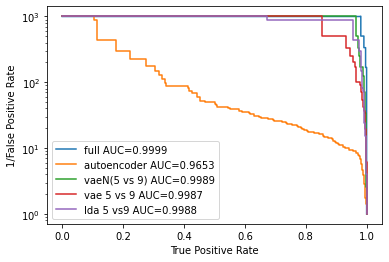

In [22]:
#model_full59     = classify    (x_tr59,x_te59,y_tr59,y_te59,256)
#model_loss59     = lossClassify(x_tr59,  x_te59,  y_tr59,  y_te59,  16,[vaeN[5],vae9],10,50)
#model_loss59N     = lossClassify(x_tr59,  x_te59,  y_tr59,  y_te59,  64,vaeN,10,100)
#lda_loss59N       = ldaClassify(x_tr5,  x_tr9,vaeN)

#Baselines
#x59_loss5 = vaeloss(vaeN[5],x_te59)
#y_pred_full59     = model_full59.predict(x_te59)
#y_pred_loss59     = lossPred(x_te59,model_loss59,[vaeN[5],vae9])
#y_pred_loss59N    = lossPred(x_te59,model_loss59N,vaeN)
#y_pred_lda59N,y_te59lda = ldaPred(x_te5,x_te9,lda_loss59N,vaeN)

plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'        ,True)
plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'autoencoder' ,False)
plot_roc_curve(y_pred_loss59N   [:,0],y_te59,fpr,tpr,'vaeN(5 vs 9)',True)
plot_roc_curve(y_pred_loss59    [:,0],y_te59,fpr,tpr,'vae 5 vs 9'  ,True)
plot_roc_curve(y_pred_lda59N    [:,0],y_te59lda,fpr,tpr,'lda 5 vs9',True)
plt.legend(loc="lower left")
plt.show()

(1901, 1568)
Train on 11370 samples, validate on 1901 samples
Epoch 1/10
11370/11370 [==============================] - 1s 62us/step - loss: 0.1114 - accuracy: 0.9654 - val_loss: 0.0931 - val_accuracy: 0.9721
Epoch 2/10
11370/11370 [==============================] - 1s 48us/step - loss: 0.0537 - accuracy: 0.9814 - val_loss: 0.0608 - val_accuracy: 0.9800
Epoch 3/10
11370/11370 [==============================] - 1s 48us/step - loss: 0.0492 - accuracy: 0.9837 - val_loss: 0.0556 - val_accuracy: 0.9779
Epoch 4/10
11370/11370 [==============================] - 1s 48us/step - loss: 0.0466 - accuracy: 0.9851 - val_loss: 0.0607 - val_accuracy: 0.9790
Epoch 5/10
11370/11370 [==============================] - 1s 48us/step - loss: 0.0420 - accuracy: 0.9861 - val_loss: 0.0581 - val_accuracy: 0.9790
Epoch 6/10
11370/11370 [==============================] - 1s 48us/step - loss: 0.0431 - accuracy: 0.9862 - val_loss: 0.0715 - val_accuracy: 0.9742
Epoch 7/10
11370/11370 [==============================] 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9653144124405019
0.99974334131827
0.9968334318487868
0.9987978151790834


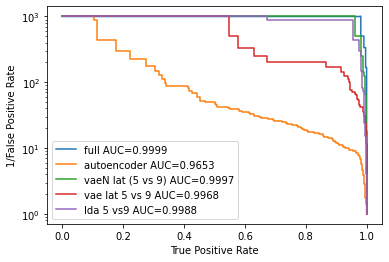

In [26]:
#Latent space too
model_lat59      = latClassify(x_tr59,  x_te59,  y_tr59,  y_te59,  32,[vaeN[5],vae9],10,50)
model_lat59N     = latClassify(x_tr59,  x_te59,  y_tr59,  y_te59,  64,vaeN,10,100)

#Baselines
y_pred_lat59     = latPred(x_te59,model_lat59,[vaeN[5],vae9])
y_pred_lat59N    = latPred(x_te59,model_lat59N,vaeN)

plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'        ,True)
plot_roc_curve(x59_loss5,             y_te59,fpr,tpr,'autoencoder' ,False)
plot_roc_curve(y_pred_lat59N   [:,0],y_te59,fpr,tpr,'vaeN lat (5 vs 9)',True)
plot_roc_curve(y_pred_lat59    [:,0],y_te59,fpr,tpr,'vae lat 5 vs 9'  ,True)
plot_roc_curve(y_pred_lda59N    [:,0],y_te59lda,fpr,tpr,'lda 5 vs9',True)
plt.legend(loc="lower left")
plt.show()

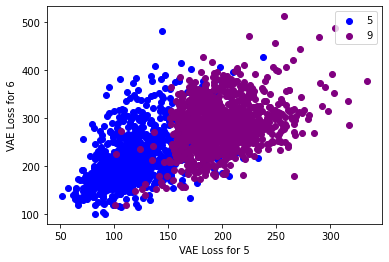

In [34]:
x5_loss5 = vaeloss(vaeN[5],x_te5)
x9_loss5 = vaeloss(vaeN[5],x_te9)

x5_loss9 = vaeloss(vaeN[6],x_te5)
x9_loss9 = vaeloss(vaeN[6],x_te9)

plt.scatter(x5_loss5, x5_loss9,c='blue' ,label='5')
plt.scatter(x9_loss5, x9_loss9,c='purple',label='9')
plt.xlabel('VAE Loss for 5') 
plt.ylabel('VAE Loss for 6') 
plt.legend(loc="upper right")
plt.show()

In [171]:
def runTheWorks(ix_tr,ix_te,iy_tr,iy_te,ix1_tr,ix1_te,iy1_tr,iy1_te,ix2_tr,ix2_te,iy2_tr,iy2_te):
    #Build VAE for signal
    vaed,gend,latd,xd,yd,mud,vae_lossd = makeModel(ix2_tr)
    vaed.fit(ix2_tr,shuffle=True,epochs=n_epoch,batch_size=batch_size,validation_data=(ix2_te, None), verbose=1)
    model_full    = classify(ix_tr,ix_te,iy_tr,iy_te,128)
    model_lossN   = lossClassify(ix_tr,ix_te,iy_tr,iy_te,64,vaeN,20,50)
    model_lat     = latClassify(ix_tr,ix_te,iy_tr,iy_te,64,vaeN,20,50)
    model_lossdn  = lossClassify(ix_tr,ix_te,iy_tr,iy_te,20,[vaeN[5],vaed],20,50)
    lda_lossN     = ldaClassify(ix1_tr,ix2_tr,vaeN)

    y_pred_lossN  = lossPred(x_te59,model_lossN,vaeN)
    y_pred_lat    = latPred(x_te59,model_lat,vaeN)
    y_pred_lossdn = lossPred(x_te59,model_lossdn,[vaeN[5],vaed])
    y_pred_full   = model_full.predict(x_te59)
    y_pred_ldaN,y_telda = ldaPred(x_te5,x_te9,lda_lossN,vaeN)

    plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'       ,True)
    plot_roc_curve(y_pred_full      [:,0],y_te59,fpr,tpr,'full sig* ' ,True)
    plot_roc_curve(y_pred_lossN     [:,0],y_te59,fpr,tpr,'vaeN class' ,True)
    plot_roc_curve(y_pred_lossdn    [:,0],y_te59,fpr,tpr,'vae sig* '  ,True)
    plot_roc_curve(y_pred_lat       [:,0],y_te59,fpr,tpr,'vaeN lat sig*',True)
    plot_roc_curve(y_pred_lda59N    [:,0],y_te59lda,fpr,tpr,'lda 5 vs 9',True)
    plot_roc_curve(y_pred_ldaN      [:,0],y_te59lda,fpr,tpr,'lda sig*'  ,True)
    plt.legend(loc="lower left")
    plt.show()
    return model_full,model_lossN,model_lat,model_lossdn,lda_lossN,vaed

def reRunTheWorks(ix_tr,ix_te,iy_tr,iy_te,ix1_tr,ix1_te,iy1_tr,iy1_te,ix2_tr,ix2_te,iy2_tr,iy2_te,model_full,model_lossN,model_lat,model_lossdn,lda_lossN,vaed):
    #Build VAE for signal
    #vaed,gend,latd,xd,yd,mud,vae_lossd = makeModel(ix2_tr)
    #vaed.fit(ix2_tr,shuffle=True,epochs=n_epoch,batch_size=batch_size,validation_data=(ix2_te, None), verbose=1)
    #model_full    = classify(ix_tr,ix_te,iy_tr,iy_te,32)
    model_lossN   = lossClassify(ix_tr,ix_te,iy_tr,iy_te,32,vaeN,64,100)
    #model_lat     = latClassify(ix_tr,ix_te,iy_tr,iy_te,32,vaeN,64,100)
    #model_lossdn  = lossClassify(ix_tr,ix_te,iy_tr,iy_te,32,[vaeN[5],vaed],20,100)
    #lda_lossN     = ldaClassify(ix1_tr,ix2_tr,vaeN)

    y_pred_lossN  = lossPred(x_te59,model_lossN,vaeN)
    y_pred_lat    = latPred(x_te59,model_lat,vaeN)
    y_pred_lossdn = lossPred(x_te59,model_lossdn,[vaeN[5],vaed])
    y_pred_full   = model_full.predict(x_te59)
    y_pred_ldaN,y_telda = ldaPred(x_te5,x_te9,lda_lossN,vaeN)

    plot_roc_curve(y_pred_full59    [:,0],y_te59,fpr,tpr,'full'       ,True)
    plot_roc_curve(y_pred_full      [:,0],y_te59,fpr,tpr,'full sig* ' ,True)
    plot_roc_curve(y_pred_lossN     [:,0],y_te59,fpr,tpr,'vaeN class' ,True)
    plot_roc_curve(y_pred_lossdn    [:,0],y_te59,fpr,tpr,'vae sig* '  ,True)
    plot_roc_curve(y_pred_lat       [:,0],y_te59,fpr,tpr,'vaeN lat sig*',True)
    plot_roc_curve(y_pred_lda59N    [:,0],y_te59lda,fpr,tpr,'lda 5 vs 9',True)
    plot_roc_curve(y_pred_ldaN      [:,0],y_te59lda,fpr,tpr,'lda sig*'  ,True)
    plt.legend(loc="lower left")
    plt.show()
    return model_full,model_lossN,model_lat,model_lossdn,lda_lossN,vaed


Total 9 sample 594 Total 5  2711


/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_819 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_819.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 3304 samples, validate on 546 samples
Epoch 1/15
3304/3304 [==============================] - 8s 2ms/step - loss: 155.7592 - val_loss: 139.3682
Epoch 2/15
3304/3304 [==============================] - 7s 2ms/step - loss: 138.1395 - val_loss: 135.4981
Epoch 3/15
3304/3304 [==============================] - 7s 2ms/step - loss: 135.1663 - val_loss: 133.1834
Epoch 4/15
3304/3304 [==============================] - 7s 2ms/step - loss: 133.9797 - val_loss: 133.8499
Epoch 5/15
3304/3304 [==============================] - 7s 2ms/step - loss: 133.2387 - val_loss: 134.4300
Epoch 6/15
3304/3304 [==============================] - 9s 3ms/step - loss: 132.8854 - val_loss: 133.2684
Epoch 7/15
3304/3304 [==============================] - 7s 2ms/step - loss: 132.7568 - val_loss: 133.2335
Epoch 8/15
3304/3304 [==============================] - 7s 2ms/step - loss: 132.7957 - val_loss: 132.4432
Epoch 9/15
3304/3304 [==============================] - 7s 2ms/step - loss: 132.5074 - val_loss: 132.5078

Epoch 5/20
6015/6015 [==============================] - 1s 213us/step - loss: 0.6355 - accuracy: 0.5549 - val_loss: 0.6378 - val_accuracy: 0.5514
Epoch 6/20
6015/6015 [==============================] - 1s 215us/step - loss: 0.6310 - accuracy: 0.5588 - val_loss: 0.6383 - val_accuracy: 0.5514
Epoch 7/20
6015/6015 [==============================] - 1s 215us/step - loss: 0.6322 - accuracy: 0.5621 - val_loss: 0.6398 - val_accuracy: 0.5383
Epoch 8/20
6015/6015 [==============================] - 1s 210us/step - loss: 0.6322 - accuracy: 0.5566 - val_loss: 0.6431 - val_accuracy: 0.5363
Epoch 9/20
6015/6015 [==============================] - 1s 208us/step - loss: 0.6358 - accuracy: 0.5709 - val_loss: 0.6436 - val_accuracy: 0.5504
Epoch 10/20
6015/6015 [==============================] - 1s 212us/step - loss: 0.6282 - accuracy: 0.5634 - val_loss: 0.6362 - val_accuracy: 0.5514
Epoch 11/20
6015/6015 [==============================] - 1s 213us/step - loss: 0.6280 - accuracy: 0.5624 - val_loss: 0.6340

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9916791477598476
0.9751674392352239
0.9863715351077967
0.9944135071353335
0.9987978151790834
0.9987278173567934


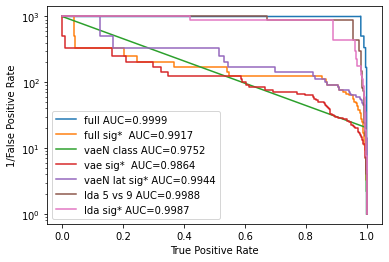

In [137]:
#Now do CWOLA with dilution
dilution=0.1
x_te9d, y_te9d = random_sample(x_te9,y_te9,dilution)
x_tr9d, y_tr9d = random_sample(x_tr9,y_tr9,dilution)
x_te5m1, y_te5m1,x_te5m2, y_te5m2 = random_split(x_te5,y_te5,0.5)
x_tr5m1, y_tr5m1,x_tr5m2, y_tr5m2 = random_split(x_tr5,y_tr5,0.5)
x_tr59d,x_te59d,y_tr59d,y_te59d     = mergeSample(x_te5m1,x_tr5m1,x_te9d,x_tr9d)
x_tr559d,x_te559d,y_tr559d,y_te559d = mergeSample(x_te5m2,x_tr5m2,x_te59d,x_tr59d)
print("Total 9 sample",len(x_tr9d),"Total 5 ",len(x_tr5m2))
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d)
#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Total 9 sample 148 Total 5  2711
Train on 5569 samples, validate on 917 samples
Epoch 1/20
5569/5569 [==============================] - 0s 48us/step - loss: 1.4483 - accuracy: 0.5037 - val_loss: 0.8978 - val_accuracy: 0.5060
Epoch 2/20
5569/5569 [==============================] - 0s 13us/step - loss: 0.8240 - accuracy: 0.5040 - val_loss: 0.7812 - val_accuracy: 0.4831
Epoch 3/20
5569/5569 [==============================] - 0s 12us/step - loss: 0.7633 - accuracy: 0.5067 - val_loss: 0.7410 - val_accuracy: 0.5093
Epoch 4/20
5569/5569 [==============================] - 0s 13us/step - loss: 0.7315 - accuracy: 0.4997 - val_loss: 0.7230 - val_accuracy: 0.4875
Epoch 5/20
5569/5569 [==============================] - 0s 13us/step - loss: 0.7247 - accuracy: 0.5170 - val_loss: 0.7232 - val_accuracy: 0.5049
Epoch 6/20
5569/5569 [==============================] - 0s 11us/step - loss: 0.7070 - accuracy: 0.5109 - val_loss: 0.6978 - val_accuracy: 0.5049
Epoch 7/20
5569/5569 [============================

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9608289964312222
0.9900780864595324
0.9628078237565942
0.9746907873977254
0.9987978151790834
0.9982322772180421


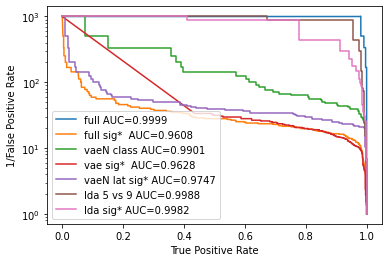

In [136]:
#Now do CWOLA with dilution
dilution=0.025
#x_te9d, y_te9d = random_sample(x_te9,y_te9,dilution)
#x_tr9d, y_tr9d = random_sample(x_tr9,y_tr9,dilution)
#x_te5m1, y_te5m1,x_te5m2, y_te5m2 = random_split(x_te5,y_te5,0.5)
#x_tr5m1, y_tr5m1,x_tr5m2, y_tr5m2 = random_split(x_tr5,y_tr5,0.5)
#x_tr59d,x_te59d,y_tr59d,y_te59d     = mergeSample(x_te5m1,x_tr5m1,x_te9d,x_tr9d)
#x_tr559d,x_te559d,y_tr559d,y_te559d = mergeSample(x_te5m2,x_tr5m2,x_te59d,x_tr59d)
print("Total 9 sample",len(x_tr9d),"Total 5 ",len(x_tr5m2))
#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

(897, 7056)
Train on 5450 samples, validate on 897 samples
Epoch 1/32
5450/5450 [==============================] - 1s 196us/step - loss: 0.6989 - accuracy: 0.5068 - val_loss: 0.6984 - val_accuracy: 0.4705
Epoch 2/32
5450/5450 [==============================] - 1s 159us/step - loss: 0.6974 - accuracy: 0.4945 - val_loss: 0.6945 - val_accuracy: 0.4838
Epoch 3/32
5450/5450 [==============================] - 1s 168us/step - loss: 0.6946 - accuracy: 0.4982 - val_loss: 0.7001 - val_accuracy: 0.4972
Epoch 4/32
5450/5450 [==============================] - 1s 162us/step - loss: 0.6923 - accuracy: 0.5149 - val_loss: 0.6959 - val_accuracy: 0.4916
Epoch 5/32
5450/5450 [==============================] - 1s 171us/step - loss: 0.6931 - accuracy: 0.5121 - val_loss: 0.6964 - val_accuracy: 0.5006
Epoch 6/32
5450/5450 [==============================] - 1s 161us/step - loss: 0.6944 - accuracy: 0.5062 - val_loss: 0.6958 - val_accuracy: 0.5017
Epoch 7/32
5450/5450 [==============================] - 1s 167us/

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9098628042683117
0.922023537045514
0.9377286039989868
0.898714262222953
0.9987978151790834
0.9858371072899954


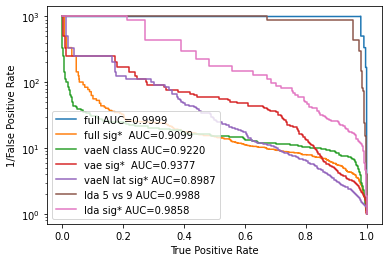

In [131]:
#Now do CWOLA with dilution
dilution=0.005
#x_te9d, y_te9d = random_sample(x_te9,y_te9,dilution)
#x_tr9d, y_tr9d = random_sample(x_tr9,y_tr9,dilution)
#x_te5m1, y_te5m1,x_te5m2, y_te5m2 = random_split(x_te5,y_te5,0.5)
#x_tr5m1, y_tr5m1,x_tr5m2, y_tr5m2 = random_split(x_tr5,y_tr5,0.5)
#x_tr59d,x_te59d,y_tr59d,y_te59d     = mergeSample(x_te5m1,x_tr5m1,x_te9d,x_tr9d)
#x_tr559d,x_te559d,y_tr559d,y_te559d = mergeSample(x_te5m2,x_tr5m2,x_te59d,x_tr59d)
#print("Total 9 sample",len(x_tr9d),"Total 5 ",len(x_tr5m2))
#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_678 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_678.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6265 samples, validate on 1028 samples
Epoch 1/15
6265/6265 [==============================] - 13s 2ms/step - loss: 114.1899 - val_loss: 102.7038
Epoch 2/15
6265/6265 [==============================] - 13s 2ms/step - loss: 102.8315 - val_loss: 100.7303
Epoch 3/15
6265/6265 [==============================] - 12s 2ms/step - loss: 101.8883 - val_loss: 100.1690
Epoch 4/15
6265/6265 [==============================] - 12s 2ms/step - loss: 101.5762 - val_loss: 101.4047
Epoch 5/15
6265/6265 [==============================] - 12s 2ms/step - loss: 101.6947 - val_loss: 100.3475
Epoch 6/15
6265/6265 [==============================] - 12s 2ms/step - loss: 101.8855 - val_loss: 102.0084
Epoch 7/15
6265/6265 [==============================] - 12s 2ms/step - loss: 102.2316 - val_loss: 102.0642
Epoch 8/15
6265/6265 [==============================] - 12s 2ms/step - loss: 102.4244 - val_loss: 101.5840
Epoch 9/15
6265/6265 [==============================] - 12s 2ms/step - loss: 102.6546 - val_loss

Epoch 4/20
11686/11686 [==============================] - 3s 233us/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0069 - val_accuracy: 0.9979
Epoch 5/20
11686/11686 [==============================] - 3s 236us/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 6/20
11686/11686 [==============================] - 3s 236us/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0136 - val_accuracy: 0.9964
Epoch 7/20
11686/11686 [==============================] - 3s 233us/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.0150 - val_accuracy: 0.9943
Epoch 8/20
11686/11686 [==============================] - 3s 234us/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 0.0638 - val_accuracy: 0.9844
Epoch 9/20
11686/11686 [==============================] - 3s 233us/step - loss: 0.0092 - accuracy: 0.9964 - val_loss: 0.0068 - val_accuracy: 0.9958
Epoch 10/20
11686/11686 [==============================] - 3s 232us/step - loss: 0.0040 - accuracy: 0.9986 - val

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9920863573133281
0.9899008697507189
0.9902880799264022
0.9976717391014501
0.9987978151790834
0.998227832911865


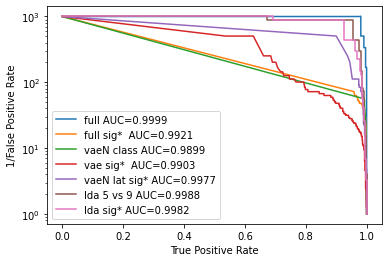

In [116]:
#x_te7 = x_te[(y_te == 7)]
#y_te7 = y_te[(y_te == 7)]
#x_tr7 = x_tr[(y_tr == 7)]
#y_tr7 = y_tr[(y_tr == 7)]
#x_tr57,x_te57,y_tr57,y_te57         = mergeSample(x_te5,x_tr5,x_te7,x_tr7)

tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr57,x_te57,y_tr57,y_te57,x_tr5,x_te5,y_tr5,y_te5,x_tr7,x_te7,y_tr7,y_te7)
#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr57,x_te57,y_tr57,y_te57,x_tr5,x_te5,y_tr5,y_te5,x_tr7,x_te7,y_tr7,y_te7,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Train on 6015 samples, validate on 992 samples
Epoch 1/20
6015/6015 [==============================] - 1s 93us/step - loss: 0.6562 - accuracy: 0.5485 - val_loss: 0.6369 - val_accuracy: 0.5625
Epoch 2/20
6015/6015 [==============================] - 0s 58us/step - loss: 0.6342 - accuracy: 0.5508 - val_loss: 0.6324 - val_accuracy: 0.5433
Epoch 3/20
6015/6015 [==============================] - 0s 57us/step - loss: 0.6288 - accuracy: 0.5536 - val_loss: 0.6315 - val_accuracy: 0.5494
Epoch 4/20
6015/6015 [==============================] - 0s 61us/step - loss: 0.6270 - accuracy: 0.5548 - val_loss: 0.6288 - val_accuracy: 0.5464
Epoch 5/20
6015/6015 [==============================] - 0s 61us/step - loss: 0.6254 - accuracy: 0.5654 - val_loss: 0.6358 - val_accuracy: 0.5565
Epoch 6/20
6015/6015 [==============================] - 0s 57us/step - loss: 0.6216 - accuracy: 0.5671 - val_loss: 0.6332 - val_accuracy: 0.5706
Epoch 7/20
6015/6015 [==============================] - 0s 60us/step - loss: 0.6182

6015/6015 [==============================] - 1s 156us/step - loss: 0.6250 - accuracy: 0.5721 - val_loss: 0.6371 - val_accuracy: 0.5333
Epoch 17/20
6015/6015 [==============================] - 1s 168us/step - loss: 0.6243 - accuracy: 0.5659 - val_loss: 0.6334 - val_accuracy: 0.5383
Epoch 18/20
6015/6015 [==============================] - 1s 167us/step - loss: 0.6253 - accuracy: 0.5653 - val_loss: 0.6373 - val_accuracy: 0.5302
Epoch 19/20
6015/6015 [==============================] - 1s 160us/step - loss: 0.6241 - accuracy: 0.5784 - val_loss: 0.6333 - val_accuracy: 0.5393
Epoch 20/20
6015/6015 [==============================] - 1s 157us/step - loss: 0.6236 - accuracy: 0.5691 - val_loss: 0.6329 - val_accuracy: 0.5423
Train on 6015 samples, validate on 992 samples
Epoch 1/20
6015/6015 [==============================] - 0s 36us/step - loss: 3.2248 - accuracy: 0.5390 - val_loss: 1.0317 - val_accuracy: 0.5423
Epoch 2/20
6015/6015 [==============================] - 0s 12us/step - loss: 0.8554 -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9896281004590968
0.5
0.9782306772678183
0.9922557964863314
0.9987978151790834
0.9987278173567934


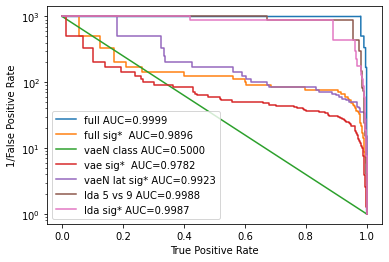

In [153]:
x_te0 = x_te[(y_te == 0)]
y_te0 = y_te[(y_te == 0)]
x_tr0 = x_tr[(y_tr == 0)]
y_tr0 = y_tr[(y_tr == 0)]
x_tr07,x_te07,y_tr07,y_te07     = mergeSample(x_te0,x_tr0,x_te7,x_tr7)
x_tr507,x_te507,y_tr507,y_te507 = mergeSample(x_te5,x_tr5,x_te07,x_tr07)

#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr507,x_te507,y_tr507,y_te507,x_tr5,x_te5,y_tr5,y_te5,x_tr07,x_te07,y_tr07,y_te07)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr559d,x_te559d,y_tr559d,y_te559d,x_tr5m2,x_te5m2,y_tr5m2,y_te5m2,x_tr59d,x_te59d,y_tr59d,y_te59d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Train on 11970 samples, validate on 1974 samples
Epoch 1/20
11970/11970 [==============================] - 1s 71us/step - loss: 0.0565 - accuracy: 0.9813 - val_loss: 0.0175 - val_accuracy: 0.9939
Epoch 2/20
11970/11970 [==============================] - 1s 58us/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.0149 - val_accuracy: 0.9949
Epoch 3/20
11970/11970 [==============================] - 1s 56us/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0202 - val_accuracy: 0.9934
Epoch 4/20
11970/11970 [==============================] - 1s 57us/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0142 - val_accuracy: 0.9949
Epoch 5/20
11970/11970 [==============================] - 1s 57us/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0162 - val_accuracy: 0.9934
Epoch 6/20
11970/11970 [==============================] - 1s 56us/step - loss: 6.8333e-04 - accuracy: 0.9998 - val_loss: 0.0121 - val_accuracy: 0.9965
Epoch 7/20
11970/11970 [==============================] - 1s 65us

Epoch 15/20
11970/11970 [==============================] - 3s 242us/step - loss: 0.0103 - accuracy: 0.9959 - val_loss: 0.0208 - val_accuracy: 0.9929
Epoch 16/20
11970/11970 [==============================] - 3s 242us/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.0213 - val_accuracy: 0.9929
Epoch 17/20
11970/11970 [==============================] - 3s 231us/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0247 - val_accuracy: 0.9929
Epoch 18/20
11970/11970 [==============================] - 3s 228us/step - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.0238 - val_accuracy: 0.9939
Epoch 19/20
11970/11970 [==============================] - 3s 231us/step - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.0201 - val_accuracy: 0.9934
Epoch 20/20
11970/11970 [==============================] - 3s 247us/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.0288 - val_accuracy: 0.9934
Train on 11970 samples, validate on 1974 samples
Epoch 1/20
11970/11970 [==============================] -

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9711314536881075
0.9927852244596835
0.968684307599319
0.9867054136093544
0.9987978151790834
0.9917558120414032


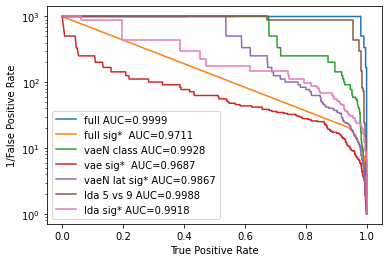

In [156]:
dilution=0.1
#x_te7d, y_te7d = random_sample(x_te7,y_te7,dilution)
#x_tr7d, y_tr7d = random_sample(x_tr7,y_tr7,dilution)
#x_tr07d,x_te07d,y_tr07d,y_te07d = mergeSample(x_te0,x_tr0,x_te7d,x_tr7d)
#x_tr507d,x_te507d,y_tr507d,y_te507d = mergeSample(x_te5,x_tr5,x_te07d,x_tr07d)

#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr507d,x_te507d,y_tr507d,y_te507d,x_tr5,x_te5,y_tr5,y_te5,x_tr07d,x_te07d,y_tr07d,y_te07d)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr507d,x_te507d,y_tr507d,y_te507d,x_tr5,x_te5,y_tr5,y_te5,x_tr07d,x_te07d,y_tr07d,y_te07d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Train on 11406 samples, validate on 1882 samples
Epoch 1/20
11406/11406 [==============================] - 1s 73us/step - loss: 0.0632 - accuracy: 0.9772 - val_loss: 0.0188 - val_accuracy: 0.9926
Epoch 2/20
11406/11406 [==============================] - 1s 59us/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0124 - val_accuracy: 0.9957
Epoch 3/20
11406/11406 [==============================] - 1s 57us/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.0111 - val_accuracy: 0.9952
Epoch 4/20
11406/11406 [==============================] - 1s 57us/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0110 - val_accuracy: 0.9957
Epoch 5/20
11406/11406 [==============================] - 1s 58us/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0127 - val_accuracy: 0.9973
Epoch 6/20
11406/11406 [==============================] - 1s 73us/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0110 - val_accuracy: 0.9968
Epoch 7/20
11406/11406 [==============================] - 1s 55us/ste

11406/11406 [==============================] - 2s 168us/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0263 - val_accuracy: 0.9936
Epoch 16/20
11406/11406 [==============================] - 2s 204us/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0263 - val_accuracy: 0.9942
Epoch 17/20
11406/11406 [==============================] - 2s 155us/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0286 - val_accuracy: 0.9936
Epoch 18/20
11406/11406 [==============================] - 2s 207us/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0260 - val_accuracy: 0.9926
Epoch 19/20
11406/11406 [==============================] - 2s 192us/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0213 - val_accuracy: 0.9957
Epoch 20/20
11406/11406 [==============================] - 2s 155us/step - loss: 0.0108 - accuracy: 0.9963 - val_loss: 0.0406 - val_accuracy: 0.9899
Train on 11406 samples, validate on 1882 samples
Epoch 1/20
11406/11406 [==============================] - 0s 25us/ste

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9621417333682952
0.985559338153924
0.9062195842796
0.9872415080419721
0.9987978151790834
0.9768807192665117


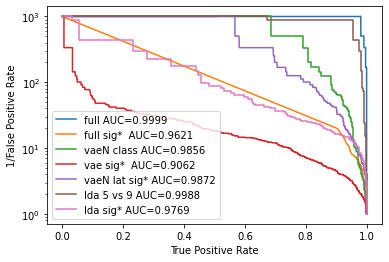

In [158]:
dilution=0.01
#x_te7d, y_te7d = random_sample(x_te7,y_te7,dilution)
#x_tr7d, y_tr7d = random_sample(x_tr7,y_tr7,dilution)
#x_tr07d,x_te07d,y_tr07d,y_te07d = mergeSample(x_te0,x_tr0,x_te7d,x_tr7d)
#x_tr507d,x_te507d,y_tr507d,y_te507d = mergeSample(x_te5,x_tr5,x_te07d,x_tr07d)

#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr507d,x_te507d,y_tr507d,y_te507d,x_tr5,x_te5,y_tr5,y_te5,x_tr07d,x_te07d,y_tr07d,y_te07d)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr507d,x_te507d,y_tr507d,y_te507d,x_tr5,x_te5,y_tr5,y_te5,x_tr07d,x_te07d,y_tr07d,y_te07d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Train on 11641 samples, validate on 1922 samples
Epoch 1/20
11641/11641 [==============================] - 0s 30us/step - loss: 0.7251 - accuracy: 0.8842 - val_loss: 0.0605 - val_accuracy: 0.9828
Epoch 2/20
11641/11641 [==============================] - 0s 12us/step - loss: 0.0400 - accuracy: 0.9882 - val_loss: 0.0607 - val_accuracy: 0.9818
Epoch 3/20
11641/11641 [==============================] - 0s 12us/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0614 - val_accuracy: 0.9849
Epoch 4/20
11641/11641 [==============================] - 0s 11us/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0624 - val_accuracy: 0.9818
Epoch 5/20
11641/11641 [==============================] - 0s 11us/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.0603 - val_accuracy: 0.9828
Epoch 6/20
11641/11641 [==============================] - 0s 12us/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.0601 - val_accuracy: 0.9828
Epoch 7/20
11641/11641 [==============================] - 0s 12us/ste

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.9996033456736902
0.9958779060207017
0.9834666254827628
0.9985839329443085
0.9987978151790834
0.9921935761998516


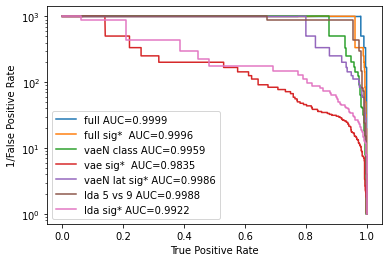

In [164]:
dilution=0.05
#x_te9d, y_te9d = random_sample(x_te9,y_te9,dilution)
#x_tr9d, y_tr9d = random_sample(x_tr9,y_tr9,dilution)
#x_tr09d,x_te09d,y_tr09d,y_te09d = mergeSample(x_te0,x_tr0,x_te9d,x_tr9d)
#x_tr509d,x_te509d,y_tr509d,y_te509d = mergeSample(x_te5,x_tr5,x_te09d,x_tr09d)

#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr509d,x_te509d,y_tr509d,y_te509d,x_tr5,x_te5,y_tr5,y_te5,x_tr09d,x_te09d,y_tr09d,y_te09d)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr509d,x_te509d,y_tr509d,y_te509d,x_tr5,x_te5,y_tr5,y_te5,x_tr09d,x_te09d,y_tr09d,y_te09d,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)

Train on 11344 samples, validate on 1872 samples
Epoch 1/64
11344/11344 [==============================] - 0s 26us/step - loss: 0.4471 - accuracy: 0.8674 - val_loss: 0.0300 - val_accuracy: 0.9899
Epoch 2/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0213 - val_accuracy: 0.9915
Epoch 3/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.0211 - val_accuracy: 0.9936
Epoch 4/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0173 - val_accuracy: 0.9941
Epoch 5/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0186 - val_accuracy: 0.9941
Epoch 6/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0196 - val_accuracy: 0.9941
Epoch 7/64
11344/11344 [==============================] - 0s 10us/ste

11344/11344 [==============================] - 0s 10us/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0202 - val_accuracy: 0.9941
Epoch 57/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0259 - val_accuracy: 0.9909
Epoch 58/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0075 - accuracy: 0.9971 - val_loss: 0.0193 - val_accuracy: 0.9947
Epoch 59/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0229 - val_accuracy: 0.9936
Epoch 60/64
11344/11344 [==============================] - 0s 10us/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0209 - val_accuracy: 0.9936
Epoch 61/64
11344/11344 [==============================] - 0s 12us/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0196 - val_accuracy: 0.9941
Epoch 62/64
11344/11344 [==============================] - 0s 12us/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.0211

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

0.999941668481425
0.6980016177274485
0.9733852724581902
0.9103539001008858
0.8496152341927139
0.9987978151790834
0.9605956703569222


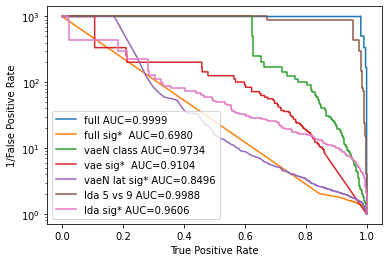

In [172]:
#x_te0 = x_te[(y_te == 0)]
#y_te0 = y_te[(y_te == 0)]
#x_tr0 = x_tr[(y_tr == 0)]
#y_tr0 = y_tr[(y_tr == 0)]
#x_tr50,x_te50,y_tr50,y_te50         = mergeSample(x_te5,x_tr5,x_te0,x_tr0)
#tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = runTheWorks(x_tr50,x_te50,y_tr50,y_te50,x_tr5,x_te5,y_tr5,y_te5,x_tr0,x_te0,y_tr0,y_te0)
tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae = reRunTheWorks(x_tr50,x_te50,y_tr50,y_te50,x_tr5,x_te5,y_tr5,y_te5,x_tr0,x_te0,y_tr0,y_te0,tmpmodel,tmpmodelloss,tmpmodellat,tmpmodellossdn,tmplda,tmpvae)